# Chapter 3. Classification Walkthrough: Titanic Dataset
Machine Learning Pocket Reference by Matt Harrison Published by O'Reilly Media, Inc., 2019 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

In [2]:
%matplotlib inline

In [6]:
#!pip install xlrd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 1.1 MB/s eta 0:00:00 MB/s eta 0:00:01


## Ask a Question

In this example, we want to create a **predictive model** to answer a question. It will classify whether an individual survives the Titanic ship catastrophe based on individual and trip characteristics. This is a toy example, but it serves as a pedagogical tool for showing many steps of modeling. Our model should be able to take passenger information and predict whether that passenger would survive on the Titanic.

This is a **classification** question, as we are predicting a label for **survival**; either they survived or they died. So we have a **binary classification** task.

## Terms for Data

We typically train a model with a **matrix of data**. (I prefer to use pandas `DataFrames` because it is very nice to have column labels, but numpy arrays work as well.)

For **supervised learning**, such as **regression or classification**, our intent is to have a fuction that transforms features into a label. If we were to write this as an algebra formula, it would look like this:
$$y = f(\textbf{X})$$

$X$ is a matrix. Each **row represents a sample of data** or information about an individual. Every **column in X is a feature**. The **output** of our function, y, is a vector that contains **labels** (for classification) or **values** (for regression).

![](https://learning.oreilly.com/library/view/machine-learning-pocket/9781492047537/assets/mlpr_0301.png)

This is standard naming procedure for naming the data and the output. If you read academic papers or even look at the documentation for libraries, they follow this convention. In Python, we use the variable name $X$ to hold the sample data even though capitalization of variables is a violation of standard naming conventions (PEP 8). Don’t worry, everyone does it, and if you were to name your variable x, they might look at you funny. The variable $y$ stores the labels or targets.

The table shows a basic dataset with two samples and three features for each sample.

|pclass|age|sibsp|
|------|---|-----|
|1|29|0|
|1|2|1|

## Gather Data

We are going to load an **Excel file** (make sure you have `pandas` and `xlrd` installed) with the Titanic features (https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic.html). It has many columns, including a survived column that contains the label of what happened to an individual:

In [7]:
url = "https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.xls"
df = pd.read_excel(url)
orig_df = df


In [8]:
df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

The following columns are included in the dataset:

- `pclass` Passenger class (1 = 1st, 2 = 2nd, 3 = 3rd)
- `survival` Survival (0 = No, 1 = Yes)
- `name` Name
- `sex` Sex
- `age` Age
- `sibsp` Number of siblings/spouses aboard
- `parch` Number of parents/children aboard
- `ticket` Ticket number
- `fare` Passenger fare
- `cabin` Cabin
- `embarked` Point of embarkation (`C` = Cherbourg, `Q` = Queenstown, `S` = Southampton)
- `boat` Lifeboat
- `body` Body identification number
- `home.dest` Home/destination

Pandas can read this spreadsheet and convert it into a `DataFrame` for us. We will need to spot-check the data and ensure that it is OK for performing analysis.

## Clean Data

Once we have the data, we need to ensure that it is in a format that we can use to create a model. Most scikit-learn models require that our features be **numeric** (`integer` or `float`). In addition, many models fail if they are passed **missing values** (`NaN` in pandas or numpy). Some models perform better if the data is **standardized** (given a mean value of $0$ and a standard deviation of $1$). We will deal with these issues using pandas or scikit-learn. In addition, the Titanic dataset has leaky features.

**Leaky features** are variables that contain information about the future or target. There’s nothing bad in having data about the target, and we often have that data during model creation time. However, if those variables are not available when we perform a prediction on a new sample, we should remove them from the model as they are leaking data from the future.

Cleaning the data can take a bit of time. It helps to have access to a subject matter expert (SME) who can provide guidance on dealing with outliers or missing data.

In [9]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

We typically see `int64, float64, datetime64[ns]`, or `object`. These are the types that pandas uses to store a column of data. `int64` and `float64` are **numeric types**. `datetime64[ns]` holds **date and time data**. `object` typically means that it is holding **string data**, though it could be a combination of string and other types.

When reading from CSV files, pandas will try to coerce data into the appropriate type, but will fall back to object. Reading data from spreadsheets, databases, or other systems may provide better types in the DataFrame. In any case, it is worthwhile to look through the data and ensure that the types make sense.

Integer types are typically fine. Float types might have some missing values. Date and string types will need to be converted or used to feature engineer numeric types. String types that have **low cardinality** are called **categorical columns**, and it might be worthwhile to create **dummy columns** from them (the `pd.get_dummies()` function takes care of this).

The `pandas-profiling` library includes a **profile report**. You can generate this report in a notebook. It will summarize the types of the columns and allow you to view details of quantile statistics, descriptive statistics, a histogram, common values, and extreme values

In [10]:
df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


In [11]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, minimal=True)

In [12]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Use the `.shape` attribute of the DataFrame to inspect the number of rows and columns:

In [13]:
df.shape

(1309, 14)

Use the `.describe` method to get **summary stats** as well as see the count of **nonnull data**. The default behavior of this method is to only report on numeric columns. Here the output is truncated to only show the first two columns

In [14]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [15]:
df.describe(include="object")

,name,sex,ticket,cabin,embarked,boat,home.dest
count,1309,1309,1309,295,1307,486,745
unique,1307,2,939,186,3,28,369
top,"Connolly, Miss. Kate",male,CA. 2343,C23 C25 C27,S,13,"New York, NY"
freq,2,843,11,6,914,39,64


In [16]:
df.describe(include="all")

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
count,1309.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307,486,121.000000,745
unique,NaN,NaN,1307,2,NaN,NaN,NaN,939,NaN,186,3,28,NaN,369
top,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S,13,NaN,"New York, NY"
freq,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914,39,NaN,64
mean,2.294882,0.381971,NaN,NaN,29.881135,0.498854,0.385027,NaN,33.295479,NaN,NaN,NaN,160.809917,NaN
std,0.837836,0.486055,NaN,NaN,14.413500,1.041658,0.865560,NaN,51.758668,NaN,NaN,NaN,97.696922,NaN
min,1.000000,0.000000,NaN,NaN,0.166700,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,1.000000,NaN
25%,2.000000,0.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN,NaN,72.000000,NaN
50%,3.000000,0.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN,155.000000,NaN
75%,3.000000,1.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN,NaN,256.000000,NaN


The count statistic only includes values that are not `NaN`, so it is useful for checking whether a column is missing data. It is also a good idea to spot-check the minimum and maximum values to see if there are **outliers**. Summary statistics are one way to do this. Plotting a histogram or a box plot is a visual representation that we will see later.

We will need to deal with missing data. Use the `.isnull` method to find columns or rows with missing values. Calling `.isnull` on a DataFrame returns a new DataFrame with every cell containing a True or False value. In Python, these values evaluate to 1 and 0, respectively. This allows us to sum them up or even calculate the percent missing (by calculating the mean).

The code indicates the count of missing data in each column:

In [17]:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

> Replace `.sum` with `.mean` to get the percentage of null values. By default, calling these methods will apply the operation along `axis 0`, which is along the index. If you want to get the counts of missing features for each sample, you can apply this along `axis 1` (along the columns):

In [18]:
df.isnull().mean() * 100

pclass        0.000000
survived      0.000000
name          0.000000
sex           0.000000
age          20.091673
sibsp         0.000000
parch         0.000000
ticket        0.000000
fare          0.076394
cabin        77.463713
embarked      0.152788
boat         62.872422
body         90.756303
home.dest    43.086325
dtype: float64

A SME can help in determining what to do with missing data. The `age` column might be useful, so keeping it and interpolating values could provide some signal to the model. Columns where **most of the values are missing** (cabin, boat, and body) tend to not provide value and can be dropped.

The `body` column (body identification number) is missing for many rows. We should drop this column at any rate because it **leaks data**. This column indicates that the passenger did not survive; by necessity our model could use that to cheat. We will pull it out. (If we are creating a model to predict if a passenger would die, knowing that they had a body identification number a priori would let us know they were already dead. We want our model to not know that information and make the prediction based on the other columns.) Likewise, the boat column leaks the reverse information (that a passenger survived).

Let’s look at some of the rows with missing data. We can create a boolean array (a series with True or False to indicate if the row has missing data) and use it to inspect rows that are missing data

In [19]:
mask = df.isnull().any(axis=1)

df[mask].head(10)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


We will impute (or derive values for) the missing values for the age column later.

Columns with type of object tend to be categorical (but they may also be high cardinality string data, or a mix of column types). For object columns that we believe to be categorical, use the `.value_counts` method to examine the counts of the values:

In [20]:
df.sex.value_counts()

male      843
female    466
Name: sex, dtype: int64

Remember that pandas typically ignores `null` or `NaN` values. If you want to include those, use `dropna=False` to also show counts for `NaN`

In [21]:
df.embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: embarked, dtype: int64

We have a couple of options for dealing with missing embarked values. Using `S` might seem logical as that is the **most common value**. We could dig into the data and try and determine if another option is better. We could also drop those two values. Or, because this is categorical, we can ignore them and use pandas to create **dummy columns** if these two samples will just have 0 entries for every option. We will use this latter choice for this feature.

## Create Features

We can drop columns that have no variance or no signal. There aren’t features like that in this dataset, but if there was a column called “is human” that had 1 for every sample this column would not be providing any information.

Alternatively, unless we are using NLP or extracting data out of text columns where **every value is different**, a model will not be able to take advantage of this column. The `name` column is an example of this. Some have pulled out the title t from the name and treated it as categorical.

We also want to drop columns that leak information. Both `boat` and `body` columns leak whether a passenger survived.

The pandas `.drop` method can drop either rows or columns:

In [22]:
df.select_dtypes("object").head(3)

,name,sex,ticket,cabin,embarked,boat,home.dest
0,"Allen, Miss. Elisabeth Walton",female,24160,B5,S,2,"St Louis, MO"
1,"Allison, Master. Hudson Trevor",male,113781,C22 C26,S,11,"Montreal, PQ / Chesterville, ON"
2,"Allison, Miss. Helen Loraine",female,113781,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON"


In [23]:
df = df.drop(columns=["name", "ticket", "home.dest", "boat", "body", "cabin"])

We need to create **dummy columns** from string columns. This will create new columns for `sex` and `embarked`. Pandas has a convenient `get_dummies` function for that

In [24]:
df = pd.get_dummies(df)

df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [25]:
df.head(10)

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,1,0,0,0,1
1,1,1,0.9167,1,2,151.5500,0,1,0,0,1
2,1,0,2.0000,1,2,151.5500,1,0,0,0,1
3,1,0,30.0000,1,2,151.5500,0,1,0,0,1
4,1,0,25.0000,1,2,151.5500,1,0,0,0,1
5,1,1,48.0000,0,0,26.5500,0,1,0,0,1
6,1,1,63.0000,1,0,77.9583,1,0,0,0,1
7,1,0,39.0000,0,0,0.0000,0,1,0,0,1
8,1,1,53.0000,2,0,51.4792,1,0,0,0,1
9,1,0,71.0000,0,0,49.5042,0,1,1,0,0


At this point the `sex_male` and `sex_female` columns are perfectly **inverse correlated**. Typically we remove any columns with perfect or very high positive or negative correlation. **Multicollinearity** can impact interpretation of feature importance and coefficients in some models. Here is code to remove the `sex_male` colum

In [26]:
df = df.drop(columns="sex_male")

Alternatively, we can add a `drop_first=True` parameter to the get_dummies call:

In [27]:
df = pd.get_dummies(df, drop_first=True)

df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

Create a `DataFrame (X)` with the features and a `series (y)` with the labels. We could also use numpy arrays, but then we don’t have column names

In [28]:
X = df.drop(columns="survived")
y = df.survived

## Sample Data

We always want to train and test on different data. Otherwise you don’t really know how well your model **generalizes** to data that it hasn’t seen before. We’ll use scikit-learn to pull out $30$% for testing (using `random_state=42` to remove an element of randomness if we start comparing different models)

In [29]:
from sklearn.model_selection import train_test_split

# here I would split with stratify=survived ...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((916, 9), (916,)), ((393, 9), (393,)))

## Impute Data

The `age` column has missing values. We need to **impute** age from the numeric values. We only want to impute on the training set and then use that imputer to fill in the date for the test set. Otherwise we are leaking data (cheating by giving future information to the model).

Now that we have test and train data, we can impute missing values on the training set, and use the trained imputers to fill in the test dataset. The fancyimpute library has many algorithms that it implements. Sadly, most of these algorithms are not implemented in an inductive manner. This means that you cannot call `.fit` and then `.transform`, which means you cannot impute for new data based on how the model was trained.

The `IterativeImputer` class (which was in fancyimpute but has been migrated to scikit-learn) does support inductive mode. To use it we need to add a special experimental import (as of scikit-learn version 0.21.2)

In [31]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=42)
X_train.loc[:,:] = imputer.fit_transform(X_train)
X_test.loc[:,:] = imputer.transform(X_test)

If we wanted to impute with the median, we can use pandas to do that (or the `SimpleImputer` class of sklearn):

In [32]:
meds = X_train.median()
X_train = X_train.fillna(meds)
X_test = X_test.fillna(meds)

## Normalize Data

**Normalizing** or preprocessing the data will help many models perform better after this is done. Particularly those that depend on a **distance metric** to **determine similarity**. (Note that tree models, which treat each feature on its own, don’t have this requirement.)

We are going to **standardize** the data for the preprocessing. **Standardizing** is translating the data so that it has a **mean value of zero** and a **standard deviation of one**. This way models don’t treat variables with larger scales as more important than smaller scaled variables. I’m going to stick the result (numpy array) back into a pandas DataFrame for easier manipulation (and to keep column names).

I also normally don’t standardize dummy columns, so I will ignore those:

In [33]:
from sklearn.preprocessing import StandardScaler

cols = X_train.columns
sca = StandardScaler()

X_train = sca.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=cols)

X_test = sca.transform(X_test)
X_test = pd.DataFrame(X_test, columns=cols)

In [34]:
X_train.mean().round(), X_train.std().round()

(pclass       -0.0
 age          -0.0
 sibsp        -0.0
 parch        -0.0
 fare          0.0
 sex_female   -0.0
 embarked_C   -0.0
 embarked_Q    0.0
 embarked_S   -0.0
 dtype: float64,
 pclass        1.0
 age           1.0
 sibsp         1.0
 parch         1.0
 fare          1.0
 sex_female    1.0
 embarked_C    1.0
 embarked_Q    1.0
 embarked_S    1.0
 dtype: float64)

## Refactor

At this point I like to refactor my code. I typically make two functions. One for **general cleaning**, and another for **dividing up into a training and testing set and to perform mutations** that need to happen differently on those sets:

In [35]:
from sklearn.experimental import enable_iterative_imputer

from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

def tweak_titanic(df):
    df = df.drop(
    columns=[
        "name",
        "ticket",
        "home.dest",
        "boat",
        "body",
        "cabin",
    ]).pipe(pd.get_dummies, drop_first=True)

    return df

def get_train_test_X_y(df, y_col, size=0.3, std_cols=None):
    y = df[y_col]
    X = df.drop(columns=y_col)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=size, random_state=42
    )
    
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    
    fi = IterativeImputer()
    
    X_train.loc[:, num_cols] = fi.fit_transform(X_train[num_cols])
    X_test.loc[:, num_cols] = fi.transform(X_test[num_cols])

    if std_cols:
        std = StandardScaler()
        X_train.loc[:, std_cols] = std.fit_transform(X_train[std_cols])
        X_test.loc[:, std_cols] = std.transform(X_test[std_cols])

    return X_train, X_test, y_train, y_test

In [36]:
ti_df = tweak_titanic(orig_df)

In [37]:
ti_df

,pclass,survived,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,0,0,1
1,1,1,0.9167,1,2,151.5500,1,0,1
2,1,0,2.0000,1,2,151.5500,0,0,1
3,1,0,30.0000,1,2,151.5500,1,0,1
4,1,0,25.0000,1,2,151.5500,0,0,1
...,...,...,...,...,...,...,...,...,...
1304,3,0,14.5000,1,0,14.4542,0,0,0
1305,3,0,NaN,1,0,14.4542,0,0,0
1306,3,0,26.5000,0,0,7.2250,1,0,0
1307,3,0,27.0000,0,0,7.2250,1,0,0


In [38]:
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(df=ti_df, y_col="survived", std_cols=std_cols)

In [39]:
X_train

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
1214,0.825248,-0.167248,-0.498616,0.0,-0.473625,1,0,1
677,0.825248,-0.205255,-0.498616,0.0,-0.488146,1,0,1
534,-0.363317,-0.751526,-0.498616,0.0,-0.145246,0,0,1
1174,0.825248,-2.153148,6.897852,2.0,0.679608,0,0,1
864,0.825248,-0.049178,-0.498616,0.0,-0.490434,0,0,1
...,...,...,...,...,...,...,...,...
1095,0.825248,-0.166508,-0.498616,0.0,-0.493196,0,1,0
1130,0.825248,-0.829564,-0.498616,0.0,-0.490434,0,0,1
1294,0.825248,-0.010159,-0.498616,0.0,-0.332756,1,0,1
860,0.825248,-0.205255,-0.498616,0.0,-0.487593,0,0,1


## Baseline Model

Creating a **baseline model** that does something really simple can give us something to compare our model to. Note that using the default `.score` result gives us the accuracy which can be misleading. A problem where a positive case is $1$ in $10,000$ can easily get over $99$% accuracy by always predicting negative.

In [40]:
from sklearn.dummy import DummyClassifier

bm = DummyClassifier(strategy="stratified")
bm.fit(X_train, y_train)
bm.score(X_test, y_test)  # accuracy is misleading for imbalanced problems

0.5089058524173028

In [41]:
from sklearn import metrics

metrics.precision_score(y_test, bm.predict(X_test))  # precision = TP / (TP + FP)

0.45

## Various Families

This code tries a variety of algorithm families. The “No Free Lunch” theorem states that no algorithm performs well on all data. However, for some finite set of data, there may be an algorithm that does well on that set. (A popular choice for structured learning these days is a tree-boosted algorithm such as **XGBoost**.)

Here we use a few different families and compare the **AUC score** and standard deviation using k-fold cross-validation. An algorithm that has a slightly smaller average score but tighter standard deviation might be a better choice.

Because we are using k-fold cross-validation, we will feed the model all of `X` and `y`.

**Me**: I do not support the last point as the test set should be kept secret and hidden especially when testing different model families. Especially because CV tests different portions of the training data it should be no problem to do CV on the training data and keep the test set for the final selected model.

In [43]:
#!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.7 MB/s eta 0:00:000m eta 0:00:01:01:01


In [44]:
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import xgboost

In [45]:
result = []
for model in [
    DummyClassifier, 
    LogisticRegression, 
    DecisionTreeClassifier, 
    KNeighborsClassifier, 
    GaussianNB, 
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier
]:
    cls = model() # we keep the defaults
    kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
    s = model_selection.cross_val_score(cls, X_train, y_train, scoring="roc_auc", cv=kfold)
    
    result.append(pd.DataFrame({'model': [model.__name__], "AUC": [s.mean()], "STD": [s.std()]}))
    print(f"{model.__name__:22} AUC: {s.mean():.3f} STD: {s.std():.2f}")
    
df_result = pd.concat(result)

DummyClassifier        AUC: 0.500 STD: 0.00
LogisticRegression     AUC: 0.824 STD: 0.03
DecisionTreeClassifier AUC: 0.765 STD: 0.07
KNeighborsClassifier   AUC: 0.809 STD: 0.06
GaussianNB             AUC: 0.803 STD: 0.04
SVC                    AUC: 0.825 STD: 0.06
RandomForestClassifier AUC: 0.833 STD: 0.06
XGBClassifier          AUC: 0.841 STD: 0.06


<AxesSubplot:xlabel='model'>

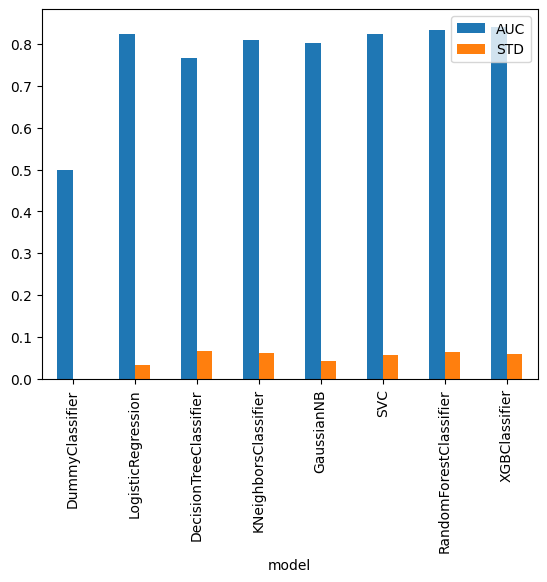

In [46]:
df_result.set_index("model").plot(kind="bar")


## Stacking

If you were going down the Kaggle route (or want **maximum performance at the cost of interpretability**), stacking is an option. A stacking classifier takes other models and uses their output to predict a target or label. We will use the previous models’ outputs and combine them to see if a stacking classifier can do better

In [48]:
#!pip install mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.0 MB/s eta 0:00:00m eta 0:00:010:00:01


In [50]:
from mlxtend.classifier import (StackingClassifier)

StackingClassifier?

Init signature:
StackingClassifier(
    classifiers,
    meta_classifier,
    use_probas=False,
    drop_proba_col=None,
    average_probas=False,
    verbose=0,
    use_features_in_secondary=False,
    store_train_meta_features=False,
    use_clones=True,
    fit_base_estimators=True,
)
Docstring:     
A Stacking classifier for scikit-learn estimators for classification.

Parameters
----------
classifiers : array-like, shape = [n_classifiers]
    A list of classifiers.
    Invoking the `fit` method on the `StackingClassifer` will fit clones
    of these original classifiers that will
    be stored in the class attribute
    `self.clfs_` if `use_clones=True` (default) and
    `fit_base_estimators=True` (default).
meta_classifier : object
    The meta-classifier to be fitted on the ensemble of
    classifiers
use_probas : bool (default: False)
    If True, trains meta-classifier based on predicted probabilities
    instead of class labels.
drop_proba_col : string (default: None)
    Dro

In [52]:
from mlxtend.classifier import (StackingClassifier)

clfs = [
    x() for x in [
        LogisticRegression,
        DecisionTreeClassifier,
        KNeighborsClassifier,
        GaussianNB,
        SVC,
        RandomForestClassifier,
    ]
]

stack = StackingClassifier(classifiers=clfs, meta_classifier=LogisticRegression())

kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)

s = model_selection.cross_val_score(stack, X_train, y_train, scoring="roc_auc", cv=kfold)

print(
 f"{stack.__class__.__name__}  "
 f"AUC: {s.mean():.3f}  STD: {s.std():.2f}"
)

StackingClassifier  AUC: 0.823  STD: 0.05


In this case it looks like performance went down a bit, as well as standard deviation.

## Create Model

I’m going to use a random forest classifier to create a model. It is a flexible model that tends to give decent out-of-the-box results. Remember to train it (calling .fit) with the training data from the data that we split earlier into a training and testing set:

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluate Model

Now that we have a model, we can use the test data to see how well the model **generalizes** to data that it hasn’t seen before. The `.score` method of a classifier returns the **average of the prediction accuracy**. We want to make sure that we call the `.score` method with the test data (presumably it should perform better with the training data):

In [54]:
rf.score(X_test, y_test)

0.7837150127226463

We can also look at other metrics, such as precision:

In [55]:
metrics.precision_score(y_test, rf.predict(X_test))

0.7916666666666666

A nice benefit of tree-based models is that you can inspect the feature importance. The **feature importance** tells you how much a **feature contributes to the model**. Note that removing a feature doesn’t mean that the score will go down accordingly, as other features might be colinear (in this case we could remove either the sex_male or sex_female column as they have a perfect negative correlation):

In [56]:
for col, val in sorted(zip(X_train.columns, rf.feature_importances_), key=lambda x: x[1], reverse=True):
    print(f"{col:10}{val:10.3f}")

age            0.285
fare           0.262
sex_male       0.241
pclass         0.089
sibsp          0.050
parch          0.039
embarked_S     0.024
embarked_Q     0.009


The feature importance is calculated by looking at the error increase. If removing a feature increases the error in the model, the feature is more important.

I really like the **SHAP library** for exploring what features a model deems important, and for explaining predictions. This library works with black-box models, and we will show it later.

## Optimize Model

Models have **hyperparameters** that control how they behave. By varying the values for these parameters, we change their **performance**. Sklearn has a **grid search** class to evaluate a model with different combinations of parameters and return the best result. We can use those parameters to instantiate the model class:

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf4 = RandomForestClassifier()
params = {
    "max_features": [0.4, "sqrt"],
    "n_estimators": [10, 50, 200, 500, 1000],
    "min_samples_leaf": [1, 2, 4, 8],
}
cv = GridSearchCV(rf4, params, n_jobs=-1).fit(X_train, y_train)
print(cv.best_params_)
print(cv.score(X_test, y_test))

rf5 = RandomForestClassifier(
    **{
        "max_features": 0.4,
        "min_samples_leaf": 4,
        "n_estimators": 1000,
    }
)
rf5.fit(X_train, y_train)
rf5.score(X_test, y_test)


{'max_features': 0.4, 'min_samples_leaf': 4, 'n_estimators': 50}
0.7938931297709924


0.7888040712468194

We can pass in a scoring parameter to `GridSearchCV` to optimize for different metrics. See Chapter 12 for a list of metrics and their meanings

### Confusion Matrix

A confusion matrix allows us to see the correct classifications as well as **false positives** and **false negatives**. It may be that we want to optimize toward false positives or false negatives, and different models or parameters can alter that. We can use `sklearn` to get a text version, or `Yellowbrick` for a plot

In [65]:
from sklearn.metrics import confusion_matrix

y_pred = rf5.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[206  18]
 [ 65 104]]


In [66]:
#!pip install yellowbrick

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 3.0 MB/s eta 0:00:000:00:01


/Users/miay/opt/miniconda3/envs/gfu-data-science/lib/python3.10/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


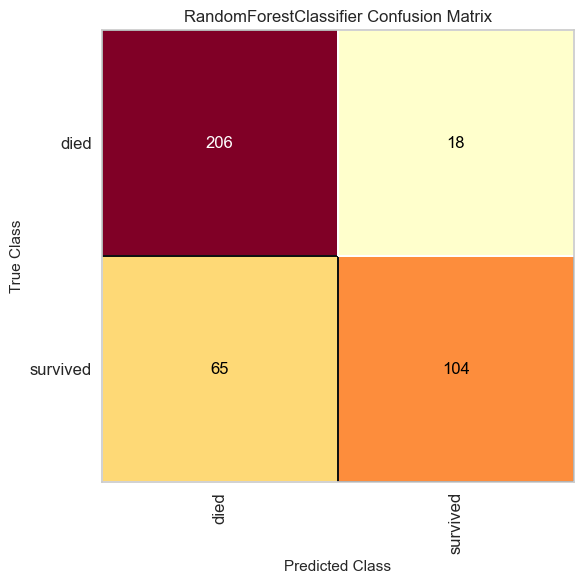

In [67]:
from yellowbrick.classifier import ConfusionMatrix

mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    rf5,
    classes=["died", "survived"],
    label_encoder=mapping,
)

cm_viz.score(X_test, y_test)
cm_viz.poof()
fig.savefig(
    "mlpr_0304.png",
     dpi=300,
     bbox_inches="tight",
)

Yellowbrick confusion matrix. This is a useful evaluation tool that presents the predicted class along the bottom and the true class along the side. A good classifier would have all of the values along the diagonal, and zeros in the other cells.

### ROC Curve

A **receiver operating characteristic (ROC)** plot is a common tool used to evaluate classifiers. By measuring the **area under the curve (AUC)**, we can get a metric to **compare different classifiers**. It plots the **true positive rate** against the **false positive rate**. We can use sklearn to calculate the AUC

In [68]:
from sklearn.metrics import roc_auc_score

y_pred = rf5.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7675137362637363

/Users/miay/opt/miniconda3/envs/gfu-data-science/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


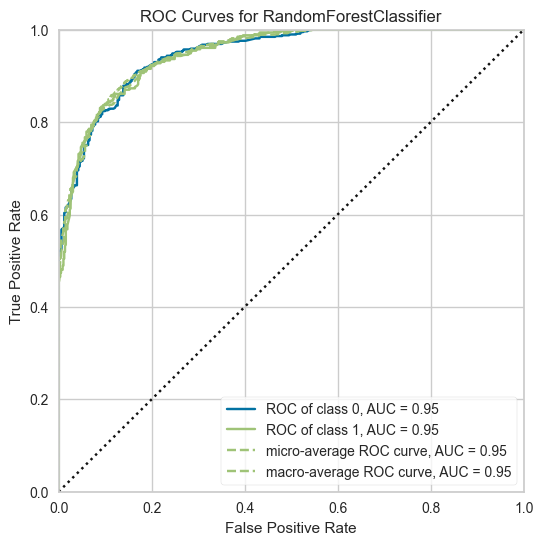

0.8764935749400093


In [69]:
from yellowbrick.classifier.rocauc import roc_auc

fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = roc_auc(rf5, X_train, y_train)
print(roc_viz.score(X_test, y_test))

roc_viz.poof()
fig.savefig("mlpr_0305.png")

### Learning Curve

A learning curve is used to tell us if we have enough training data. It trains the model with increasing portions of the data and measures the score. If the cross-validation score continues to climb, then we might need to **invest in gathering more data**. Here is a Yellowbrick example

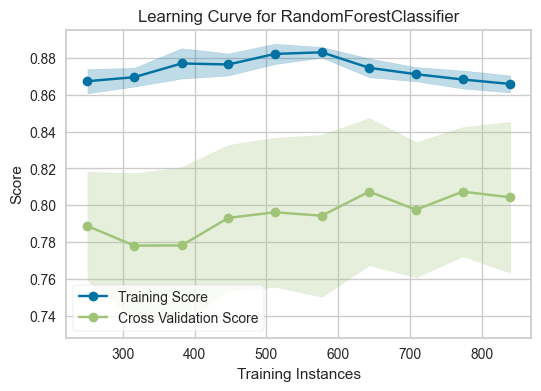

In [70]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import LearningCurve

fig, ax = plt.subplots(figsize=(6, 4))
cv = StratifiedKFold(n_splits=12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(
    rf5,
    cv=cv,
    train_sizes=sizes,
    scoring="f1_weighted",
    n_jobs=4,
    ax=ax,
)
lc_viz.fit(X_train, y_train)
lc_viz.poof()
fig.savefig("mlpr_0306.png")